In [2]:
import numpy as np
import networkx as nx
import random as rd
import math
import os
import matplotlib.pyplot as plt
import json
import time

# PoW Blockchain Simulator

In [31]:
class PoW:

    def __init__(self, ntwk, params, seeds):
        self.ntwk = ntwk
        self.params = params
        self.time = 0
        # Is the prev_block = 0 important here?
        self.global_blockchain = {0: {"level": 0, "prev_block": 0, "miner": -1, "time_created": 0, "n_transactions": 0, "children" : []}}
        self.global_levels = {0: [0]}
        self.total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        self.N = len(self.ntwk.nodes())
        self.newest_block_id = 0
        self.transaction_pool = 0
        self.signals = {}
        self.changed_blockchain_nodes = []
        self.measures = {
            "TPS" : [],
            "storage_ratio" : [],
            "fork_rate" : [],
            "fork_ratio" : [],
            "orphaned_ratio" : [],
            "consensus" : [],
            "percent_mining_longest_chain" : []
        }
        self.rng_poisson_noise = np.random.default_rng(seeds["poisson_noise"])
        self.rng_poisson_new_transactions = np.random.default_rng(seeds["poisson_new_transactions"])
        self.rng_uniform_activity = np.random.default_rng(seeds["uniform_activity"])
        self.rng_exponential_minetime = np.random.default_rng(seeds["exponential_minetime"])

    def randomSignalNoise(self):
        # Random Noise CANNOT be negative
        return self.rng_poisson_noise.poisson(self.params["avg_signal_noise"])

    def addNewTransactions(self):
        self.transaction_pool += self.rng_poisson_new_transactions.poisson(self.params["avg_transaction_rate"])

    # Create number of transactions for nodes to add to the block they're mining on
    def getNumTransactions(self):
        return max(1, min(self.transaction_pool, self.params["max_n_transactions"]))

    def sendSignal(self, node, block_id):
        # Send signal to all neighbors of node
        for nb in self.ntwk.neighbors(node):
            # Calculate arrival time of signal for neighbor "nb"
            arrival_time = self.time + round(self.global_blockchain[block_id]["n_transactions"]/self.ntwk[node][nb]["bandwidth"]) + self.randomSignalNoise()

            # Handle missing arrival_time and nb cases
            if not (arrival_time in self.signals):
                self.signals[arrival_time] = {}
            if not (nb in self.signals[arrival_time]):
                self.signals[arrival_time][nb] = []

            # Add block_id in "arrival_time" at correct neighbor "nb"
            self.signals[arrival_time][nb].append(block_id)

    # Adds the new block to both global and node's local blockchain and updates both global and node's local levels
    def addNewBlock(self, node):
        # Level to add newly mined block = Level of block that node was mining on + 1
        level = self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["level"] + 1
        # or, as it better be mining on longest chain block, level = max(list(self.ntwk.nodes[node]["local_levels"])) + 1

        # Creates new block and updates global_blockchain
        self.global_blockchain[self.newest_block_id] = {"level": level, "prev_block": self.ntwk.nodes[node]["mining"]["block_id"], "miner": node, "time_created": self.time, "n_transactions": self.ntwk.nodes[node]["mining"]["n_transactions"], "children" : []}
        
        # Subtract n_transactions away from transaction_pool
        self.transaction_pool -= self.ntwk.nodes[node]["mining"]["n_transactions"]

        # Adds itself to the "children" of its prev_block
        self.global_blockchain[self.ntwk.nodes[node]["mining"]["block_id"]]["children"].append(self.newest_block_id)
        
        # Updates global_levels
        if not (level in self.global_levels):
            self.global_levels[level] = []
        self.global_levels[level].append(self.newest_block_id)

        # Updates local_blockchain
        self.ntwk.nodes[node]["local_blockchain"][self.newest_block_id] = self.time

        # Updates local_levels (note that the condition must always be true, but I still added the "if" condition just in case)
        if not (level in self.ntwk.nodes[node]["local_levels"]):
            self.ntwk.nodes[node]["local_levels"][level] = []
        self.ntwk.nodes[node]["local_levels"][level].append(self.newest_block_id)

        # Adds node to changed_blockchain_nodes
        self.changed_blockchain_nodes.append(node)

    def verifyAddingBlockToNode(self, node, level, block_id) -> bool:
        if (level - 1) in self.ntwk.nodes[node]["local_levels"]:
            for block in self.ntwk.nodes[node]["local_levels"][level - 1]:
                if block == self.global_blockchain[block_id]["prev_block"]:
                    return True
        return False

    # CHANGE LOCAL BLOCKCHAIN TO ONLY HAVE BLOCK ID AND TIME IT RECEIVED IT
    def addBlockToLocalBlockchainFromSignal(self, node, block_id):
        level = self.global_blockchain[block_id]["level"]

        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

        else: # Adds block_id to storage with correct level key
            if not (level in self.ntwk.nodes[node]["storage"]):
                self.ntwk.nodes[node]["storage"][level] = []
            self.ntwk.nodes[node]["storage"][level].append(block_id)
            # Adding this node to changed_blockchain_nodes after a block has been added into its storage is unnecessary.
            # If and when a storage block does finally find a place to fit into the local blockchain,
            # That would only happen after the local blockchain has been changed by some block getting added in it,
            # And in that case, the node would be added into changed_blockchain_nodes anyway and the storage would get fixed.

    def tryAddBlockToLocalBlockchainFromStorage(self, node, level, block_id):
        if self.verifyAddingBlockToNode(node, level, block_id):
            self.ntwk.nodes[node]["local_blockchain"][block_id] = self.time

            if not (level in self.ntwk.nodes[node]["local_levels"]):
                self.ntwk.nodes[node]["local_levels"][level] = []
            self.ntwk.nodes[node]["local_levels"][level].append(block_id)
            
            # Adds node to changed_blockchain_nodes
            self.changed_blockchain_nodes.append(node)

            self.ntwk.nodes[node]["storage"][level].remove(block_id)
            
    # Handles mining
    def allMining(self):
        for node in self.ntwk.nodes():
            # Checks mining status of "node"
            if self.time == self.ntwk.nodes[node]["mining"]["mine_time"]:
                # Increase newest block id by 1
                self.newest_block_id += 1
                # Add new block to global and local blockchains
                self.addNewBlock(node)
                # Send signal to all neighbors
                self.sendSignal(node, self.newest_block_id)

    def handleSignals(self):
        # If there exist signals supposed to arrive at current time
        if self.time in self.signals:
            # For all nodes supposed to receive those signals
            for node in self.signals[self.time]:
                # Add all blocks that the particular node was supposed to receive to the node local blockchain
                for block_id in self.signals[self.time][node]:
                    self.addBlockToLocalBlockchainFromSignal(node, block_id)
            # Free up memory by deleting the current time signals list
            del self.signals[self.time]

    # For a node, checks all block ids in storage and tries to add them in local blockchain
    def checkNodeStorage(self, node):
        levels = list(self.ntwk.nodes[node]["storage"].keys())
        levels.sort()
        for level in levels:
            for block_id in self.ntwk.nodes[node]["storage"][level]:
                self.tryAddBlockToLocalBlockchainFromStorage(node, level, block_id)

    # Checks if a node is mining on the longest chain block, and restarts it if it is not
    def checkNodeRestart(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]

        # If the block it is mining on isn't longest_chain_block_id, then restart mining on this new block
        if self.ntwk.nodes[node]["mining"]["block_id"] != longest_chain_block_id:
            self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # Restarts a node forcefully
    def restartNode(self, node):
        highest_level = max(list(self.ntwk.nodes[node]["local_levels"]))
        longest_chain_block_id = self.ntwk.nodes[node]["local_levels"][highest_level][0]
        self.ntwk.nodes[node]["mining"]["block_id"] = longest_chain_block_id
        self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
        self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()

    # For every changed blockchain nodes, checks its storage and whether it requires restart
    def checkNodes(self):
        for _ in range(len(self.changed_blockchain_nodes)):
            # Pop the node out to free up memory
            node = self.changed_blockchain_nodes.pop(0)
            self.checkNodeStorage(node)
            self.checkNodeRestart(node)

    # Get longest chain's latest block id, which is the first block in the highest global level
    def getLongestChainLatestBlockId(self):
        return self.global_levels[max(list(self.global_levels))][0]
    
    def getLongestChain(self):
        longest_chain = []

        # Get longest chain's latest block id, which is the first block in the highest global level
        block_id = self.getLongestChainLatestBlockId()

        # WHY WAS THIS WRITTEN IN PLACE OF ABOVE BEFORE? IT HAS LOCAL LEVELS NOT GLOBAL, AND node VARIABLE ISN'T EVEN DEFINED
        # block_id = self.ntwk.nodes[node]["local_levels"][max(list(self.global_levels))][0]

        while block_id != 0:
            longest_chain.append(block_id)
            block_id = self.global_blockchain[block_id]["prev_block"]
        
        return longest_chain

    def measureTPS(self):
        # self.time will not be 0 as it is incremented to 1 at the start of the very first iteration
        return sum(self.global_blockchain[block_id]["n_transactions"] for block_id in self.getLongestChain())/self.time

    # Ratio of total number of blocks in storage across all nodes to total number of blocks
    def measureStorageRatio(self):
        if self.newest_block_id == 0 : return 0
        return sum(len(self.ntwk.nodes[node]["storage"][level]) for node in self.ntwk.nodes() for level in self.ntwk.nodes[node]["storage"])/self.newest_block_id

    # Two measures - Rate of forks; and Ratio of number of forks to total number of blocks
    def measureForkRateAndRatio(self):
        if self.newest_block_id == 0 : return {"rate" : 0, "ratio" : 0}
        func = lambda l : l - 1 if l >= 2 else 0
        forks = sum(func(len(self.global_blockchain[block_id]["children"])) for block_id in self.global_blockchain)
        return {"rate" : forks/self.time, "ratio" : forks/self.newest_block_id}

    # Ratio of number of orphaned blocks to total number of blocks
    def measureOrphanedBlocksRatio(self):
        if self.newest_block_id == 0 : return 0
        return (self.newest_block_id - len(self.getLongestChain()))/self.newest_block_id

    # Measure the distribution of lengths of chains that have been reverted and abandoned
    def measureRevertRate(self):
        pass

    # Check the consensus on blockchain - till when do they all agree and by how much?
    def measureConsensus(self):
        num_nodes_mining_on_block = {}
        for node in self.ntwk.nodes():
            if not (self.ntwk.nodes[node]["mining"]["block_id"] in num_nodes_mining_on_block):
                num_nodes_mining_on_block[self.ntwk.nodes[node]["mining"]["block_id"]] = 0
            num_nodes_mining_on_block[self.ntwk.nodes[node]["mining"]["block_id"]] += 1
        return sum((num_nodes_mining_on_block[block_id]/self.N)**2 for block_id in num_nodes_mining_on_block)

    def measurePercentMiningOnLongestChain(self):
        longest_chain_latest_block = self.getLongestChainLatestBlockId()
        return sum((self.ntwk.nodes[node]["mining"]["block_id"] == longest_chain_latest_block) for node in self.ntwk.nodes())/self.N

    def runMeasures(self):
        self.measures["TPS"].append(self.measureTPS())
        self.measures["storage_ratio"].append(self.measureStorageRatio())
        fork_measures = self.measureForkRateAndRatio()
        self.measures["fork_rate"].append(fork_measures["rate"])
        self.measures["fork_ratio"].append(fork_measures["ratio"])
        self.measures["orphaned_ratio"].append(self.measureOrphanedBlocksRatio())
        self.measures["consensus"].append(self.measureConsensus())
        self.measures["percent_mining_longest_chain"].append(self.measurePercentMiningOnLongestChain())

    def initializeNetwork(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["mining"] = {}
            self.ntwk.nodes[node]["mining"]["block_id"] = 0
            self.ntwk.nodes[node]["mining"]["mine_time"] = self.time + round(self.rng_exponential_minetime.exponential(self.params["avg_mine_time"] * self.total_power/self.ntwk.nodes[node]["power"]))
            self.ntwk.nodes[node]["mining"]["n_transactions"] = self.getNumTransactions()
            self.ntwk.nodes[node]["local_blockchain"] = {0: 0}
            self.ntwk.nodes[node]["local_levels"] = {0: [0]}
            self.ntwk.nodes[node]["storage"] = {}

    def runSimulation(self):
        self.allminingtime = 0
        self.handlesignalstime = 0
        self.addnewtranstime = 0
        self.runmeasurestime = 0
        self.checknodestime = 0
        self.addNewTransactions()
        self.initializeNetwork()
        while (self.time < self.params["run_time"]):
            self.time += 1
            s = time.time()
            self.addNewTransactions()
            e = time.time()
            self.addnewtranstime += e - s
            s = time.time()
            self.allMining()
            e = time.time()
            self.allminingtime += e - s
            s = time.time()
            self.handleSignals()
            e = time.time()
            self.handlesignalstime += e - s
            # self.measures() should go here as self.checkNodes() deletes some data like storage that self.measure() might need
            s = time.time()
            self.runMeasures()
            e = time.time()
            self.runmeasurestime += e - s
            s = time.time()
            self.checkNodes()
            e = time.time()
            self.checknodestime += e - s

# Create the Network

In [37]:
class UniRnNtwkTriInqGenerator:

    def __init__(self, params, seeds):
        self.params = params
        self.ntwk = nx.complete_graph(self.params["n"])
        self.seeds = seeds

    def generateScatter(self):
        rng_uniform_scatter = np.random.default_rng(self.seeds["scatter"])
        self.X = rng_uniform_scatter.uniform(size=(self.params["n"], 2))

    def assignPower(self):
        rng_pareto_power = np.random.default_rng(self.seeds["power"])
        for i in range(self.params["n"]):
            self.ntwk.nodes[i]["power"] = rng_pareto_power.pareto(self.params["pareto_param"]) + 1

    def assignBandwidth(self):
        for i in range(self.params["n"] - 1):
            for j in range(i + 1, self.params["n"]):
                self.ntwk[i][j]["bandwidth"] = self.params["bandwidth_factor"]/np.linalg.norm(self.X[i] - self.X[j])

    def assignActivity(self):
        rng_uniform_activity = np.random.default_rng(self.seeds["activity"])
        for i in range(self.params["n"]):
            self.ntwk.nodes[i]["active"] = (rng_uniform_activity.uniform() < self.params["active_prob"])

    def plotAll(self):
        plt.scatter(self.X[:,0], self.X[:,1], c=[self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes])
        plt.title("All Nodes")
        plt.colorbar()
        plt.show()

    def getStats(self):
        total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        print(f"Total Power : {total_power}")
        print(f"Max power : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Max power share : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Min power : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Min power share : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Max bandwidth : {max([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")
        print(f"Min bandwidth : {min([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")

    def createNetwork(self):
        self.generateScatter()
        self.assignPower()
        self.assignBandwidth()
        # self.assignActivity()
        self.getStats()

    def getNetwork(self):
        return self.ntwk

In [25]:
ntwk_params = {
    "n" : 1000,
    "pareto_param" : 1.1,
    "bandwidth_factor" : 10,
    "active_prob" : 1,
}
ntwk_seeds = {
    "scatter" : 1,
    "power" : 2,
    "activity" : 3
}

In [26]:
ntwk = UniRnNtwkTriInqGenerator(ntwk_params, ntwk_seeds)
ntwk.createNetwork()

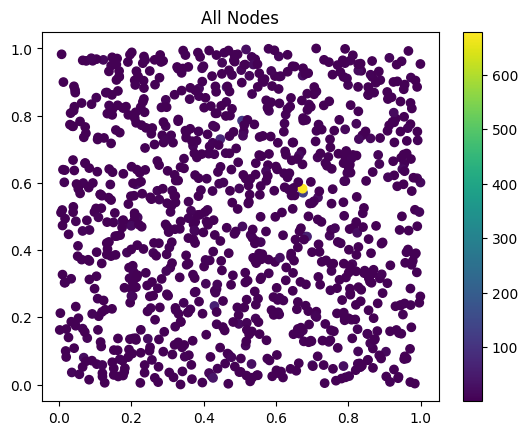

In [27]:
ntwk.plotAll()

In [28]:
pow_params1 = {
    "run_time" : 2000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 500,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds1 = {
    "poisson_noise" : 10,
    "poisson_new_transactions" : 11,
    "uniform_activity" : 12,
    "exponential_minetime" : 13
}

In [8]:
pow_params2 = {
    "run_time" : 2000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 1000,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds2 = {
    "poisson_noise" : 14,
    "poisson_new_transactions" : 15,
    "uniform_activity" : 16,
    "exponential_minetime" : 17
}

In [9]:
pow_params3 = {
    "run_time" : 2000,
    "avg_mine_time" : 100,
    "max_n_transactions" : 2000,
    "avg_signal_noise" : 5,
    "activate" : 0,
    "deactivate" : 0,
    "avg_transaction_rate" : 50
}
pow_seeds3 = {
    "poisson_noise" : 18,
    "poisson_new_transactions" : 19,
    "uniform_activity" : 20,
    "exponential_minetime" : 21
}

In [42]:
sims = ["sim1", "sim2", "sim3"]

pow_params = {
    "run_time" : [2000, 2000, 2000],
    "avg_mine_time" : [100, 100, 100],
    "max_n_transactions" : [500, 1000, 2000],
    "avg_signal_noise" : [5, 5, 5],
    "activate" : [0, 0, 0],
    "deactivate" : [0, 0, 0],
    "avg_transaction_rate" : [50, 50, 50]
}
pow_seeds = {
    "poisson_noise" : [10, 14, 18],
    "poisson_new_transactions" : [11, 15, 19],
    "uniform_activity" : [12, 16, 20],
    "exponential_minetime" : [13, 17, 21]
}

measures = [
    "TPS",
    "storage_ratio",
    "fork_rate",
    "fork_ratio",
    "orphaned_ratio",
    "consensus",
    "percent_mining_longest_chain"
]

In [ ]:
fig, axs = plt.subplots(3,3)

for k in range(len(sims)):
    sim = PoW(
        ntwk.getNetwork().copy(),
        {key : pow_params[key][k] for key in pow_params.keys()},
        {key : pow_seeds[key][k] for key in pow_seeds.keys()}
    )
    print(f"Running {sims[k]}")
    start = time.time()
    sim.runSimulation()
    end = time.time()
    print(f"{sims[k]} ran in {end-start} seconds")
    w = 0
    for i in range(3):
        for j in range(3):
            axs[i][j].plot(list(range(sim.params["run_time"])), sim.measures[measures[w]], label=sims[k])
            axs[i][j].set_title(measures[w])
            axs[i][j].legend()
            w += 1
            if w > 6: break

plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

In [32]:
sim1 = PoW(ntwk.getNetwork().copy(), pow_params1, pow_seeds1)

In [205]:
sim2 = PoW(ntwk.getNetwork().copy(), pow_params2, pow_seeds2)

In [206]:
sim3 = PoW(ntwk.getNetwork().copy(), pow_params3, pow_seeds3)

In [33]:
sim1.runSimulation()

In [35]:
print(f"All Mining : {sim1.allminingtime}")
print(f"Handle Signals : {sim1.handlesignalstime}")
print(f"New Trans : {sim1.addnewtranstime}")
print(f"Run Measures : {sim1.runmeasurestime}")
print(f"Check Nodes : {sim1.checknodestime}")

All Mining : 0.6220343112945557
Handle Signals : 0.06164050102233887
New Trans : 0.011512041091918945
Run Measures : 2.201070547103882
Check Nodes : 0.09788203239440918


In [17]:
print(sim1.activity_changes)

0


In [208]:
sim2.runSimulation()

In [209]:
sim3.runSimulation()

In [210]:
print(sim1.activity_changes)

0


NameError: name 'sim2' is not defined

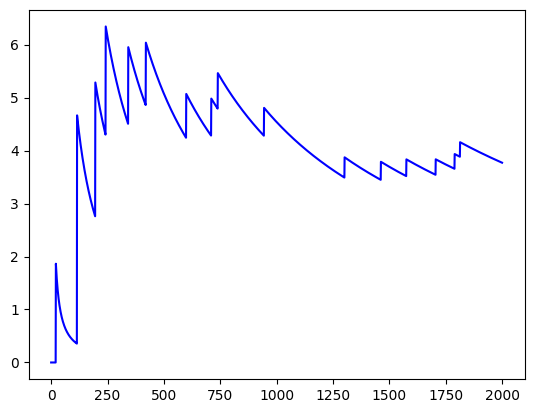

In [36]:
st = "TPS"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

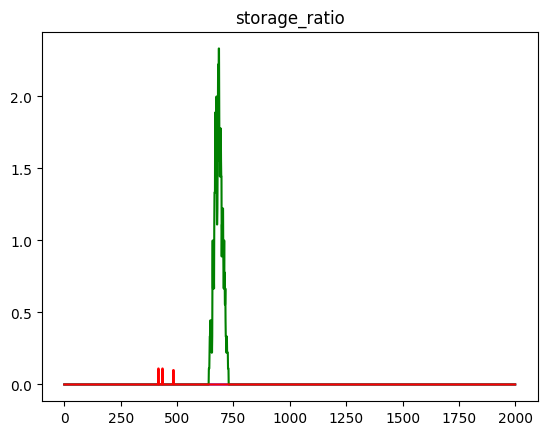

In [212]:
st = "storage_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

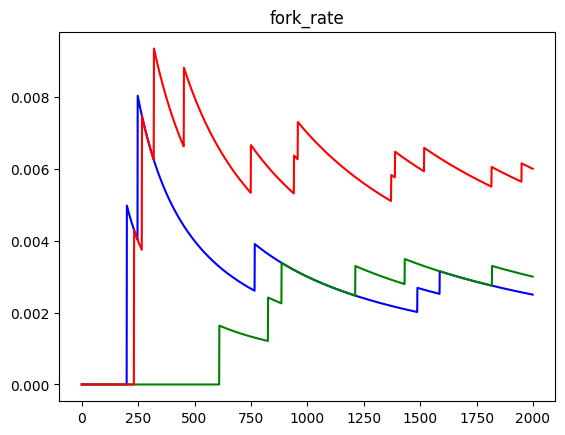

In [213]:
st = "fork_rate"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

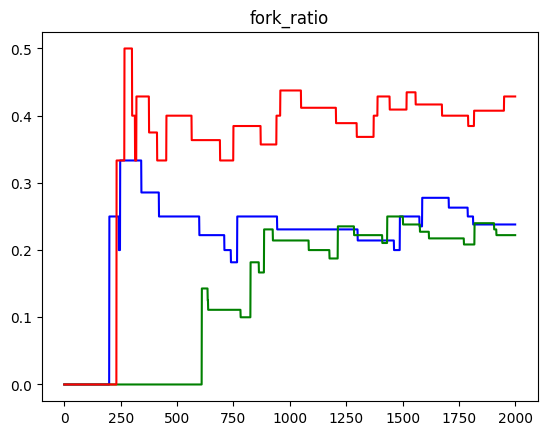

In [214]:
st = "fork_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

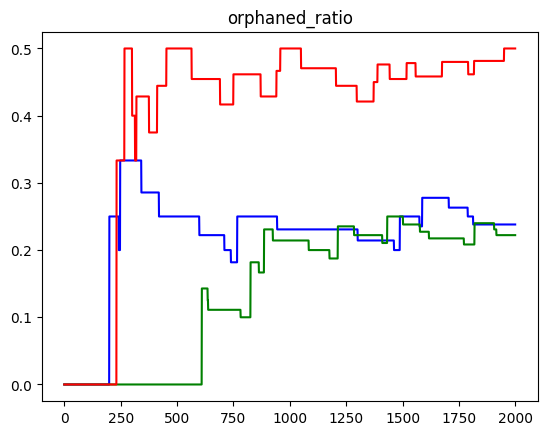

In [215]:
st = "orphaned_ratio"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

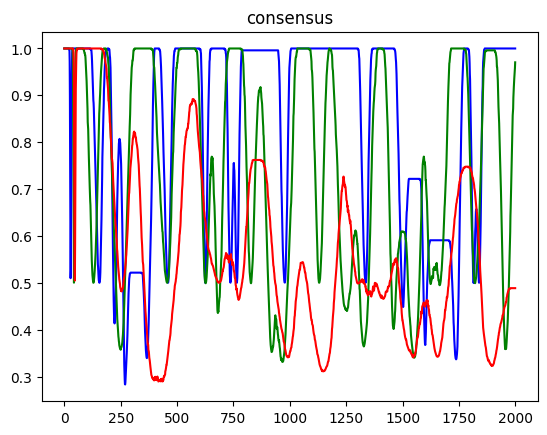

In [216]:
st = "consensus"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

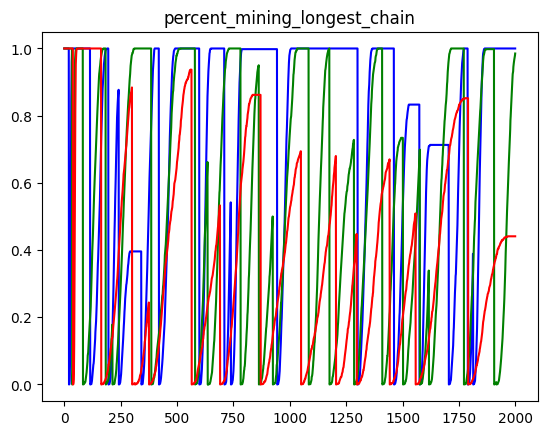

In [217]:
st = "percent_mining_longest_chain"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

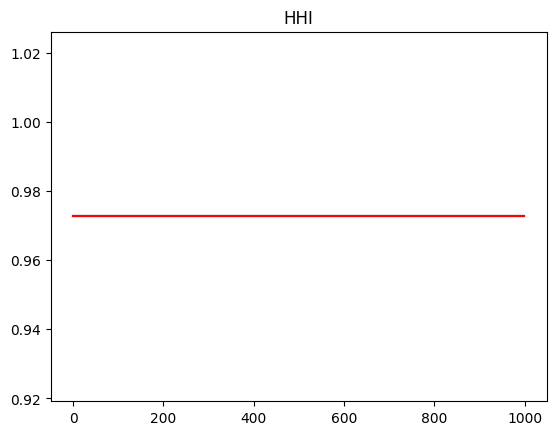

In [181]:
st = "HHI"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

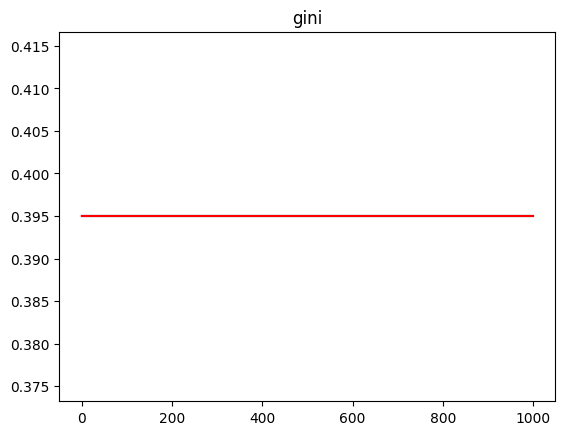

In [180]:
st = "gini"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

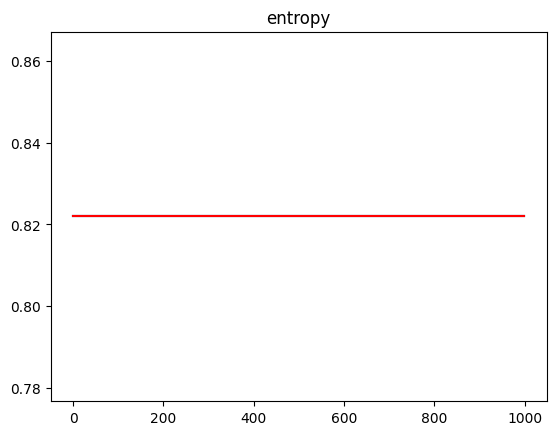

In [179]:
st = "entropy"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

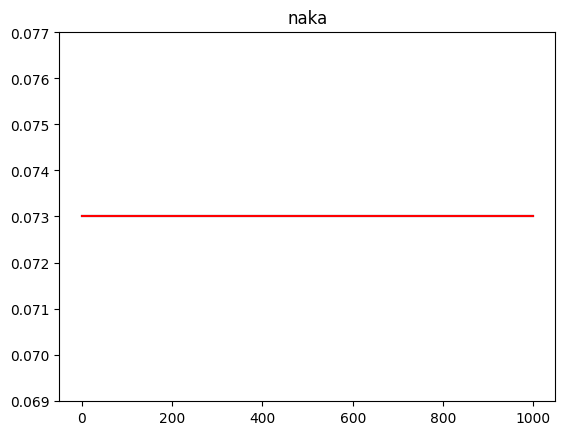

In [178]:
st = "naka"
plt.plot(list(range(sim1.params["run_time"])), sim1.measures[st], color="blue", label="sim1")
plt.plot(list(range(sim2.params["run_time"])), sim2.measures[st], color="green", label="sim2")
plt.plot(list(range(sim3.params["run_time"])), sim3.measures[st], color="red", label="sim3")
plt.title(st)
plt.show()

In [ ]:
class RandomNetwork:

    def __init__(self, n):
        self.n = n
        self.folder = folder

    def createGraph(self):
        self.ntwk = nx.complete_graph(self.n)
        
    def assignPower(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["power"] = np.random.pareto(1.2) + 1

    def assignWeights(self):
        for edge in self.ntwk.edges:
            self.ntwk.edges[edge]["bandwidth"] = 100/np.random.lognormal(1,0.7)

    def assignActiveOrInactive(self):
        for node in self.ntwk.nodes():
            self.ntwk.nodes[node]["active"] = (np.random.random() < 0.25)

    def createNetwork(self):
        self.createGraph()
        self.assignPower()
        self.assignWeights()
        self.assignActiveOrInactive()
        self.getStats()

    def getStats(self):
        total_power = sum(self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes())
        print(f"Total Power : {total_power}")
        print(f"Max power : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Max power share : {max([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Min power : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])}")
        print(f"Min power share : {min([self.ntwk.nodes[node]["power"] for node in self.ntwk.nodes()])/total_power}")
        print(f"Max bandwidth : {max([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")
        print(f"Min bandwidth : {min([self.ntwk.edges[edge]["bandwidth"] for edge in self.ntwk.edges()])}")

    def writeNetwork(self):
        pass

    def getNetwork(self):
        return self.ntwk